In [1]:
import pandas as pd

In [4]:
x_train = pd.read_csv('store-sales-time-series-forecasting/train.csv')

In [12]:
x_train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [36]:
x_train['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [39]:
x_train['store_nbr'].unique()

array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  4,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  5, 50, 51, 52, 53, 54,  6,
        7,  8,  9])

In [47]:
store_sales = x_train.set_index('date')
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)
average_sales = store_sales.groupby('date').mean()['sales']

In [48]:
store_sales.head()

id  sales  onpromotion
date       store_nbr family                            
2013-01-01 1         AUTOMOTIVE   0    0.0            0
                     BABY CARE    1    0.0            0
                     BEAUTY       2    0.0            0
                     BEVERAGES    3    0.0            0
                     BOOKS        4    0.0            0

In [49]:
average_sales.head()

date
2013-01-01      1.409438
2013-01-02    278.390807
2013-01-03    202.840197
2013-01-04    198.911154
2013-01-05    267.873244
Name: sales, dtype: float64

### Time Step Features

In [50]:
df = average_sales.to_frame()
df.head()

,sales
date,
2013-01-01,1.409438
2013-01-02,278.390807
2013-01-03,202.840197
2013-01-04,198.911154
2013-01-05,267.873244


In [52]:
from sklearn.linear_model import LinearRegression

In [55]:
time = np.arange(len(df.index))
df['time'] = time 

In [56]:
df.head()

,sales,time
date,,
2013-01-01,1.409438,0
2013-01-02,278.390807,1
2013-01-03,202.840197,2
2013-01-04,198.911154,3
2013-01-05,267.873244,4


In [57]:
X = df.loc[:, ['time']]  # features
y = df.loc[:, 'sales']  # target

In [58]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [59]:
y_pred = model.predict(X)

In [62]:
y_pred[:10]

array([194.23279017, 194.42713713, 194.62148408, 194.81583103,
       195.01017798, 195.20452493, 195.39887188, 195.59321883,
       195.78756578, 195.98191273])

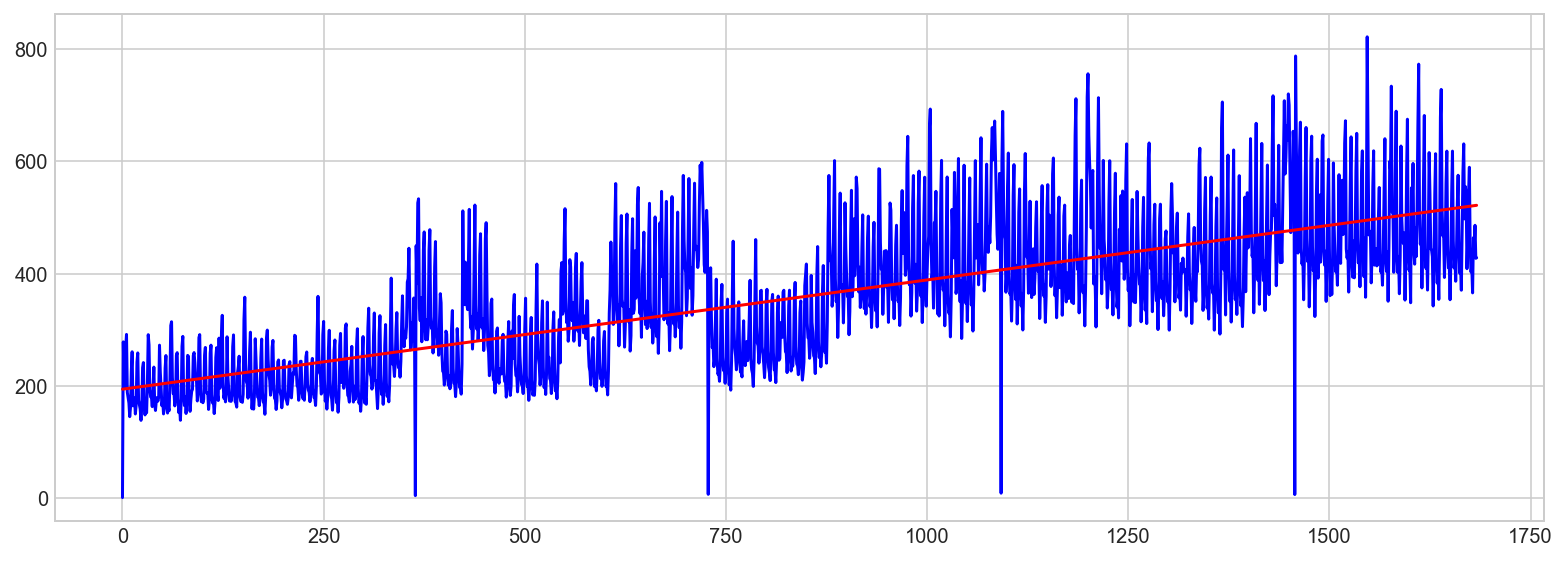

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(X['time'], y, color='blue', label='Actual vs Predicted')
plt.plot(X['time'], y_pred, color='red', label='Actual vs Predicted')

### Lag  Features


In [74]:
lag_1 = df['sales'].shift(1)
df['lag_1'] = lag_1  # add to dataframe

In [75]:
df.head()

,sales,time,lag_1
date,,,
2013-01-01,1.409438,0,NaN
2013-01-02,278.390807,1,1.409438
2013-01-03,202.840197,2,278.390807
2013-01-04,198.911154,3,202.840197
2013-01-05,267.873244,4,198.911154


In [87]:
X = df.loc[:, ['lag_1']].dropna()
y = df.loc[:, 'sales']

In [88]:
y, X = y.align(X, join='inner')

In [91]:
model = LinearRegression()
model.fit(X,y)

LinearRegression()

In [92]:
y_pred = model.predict(X)

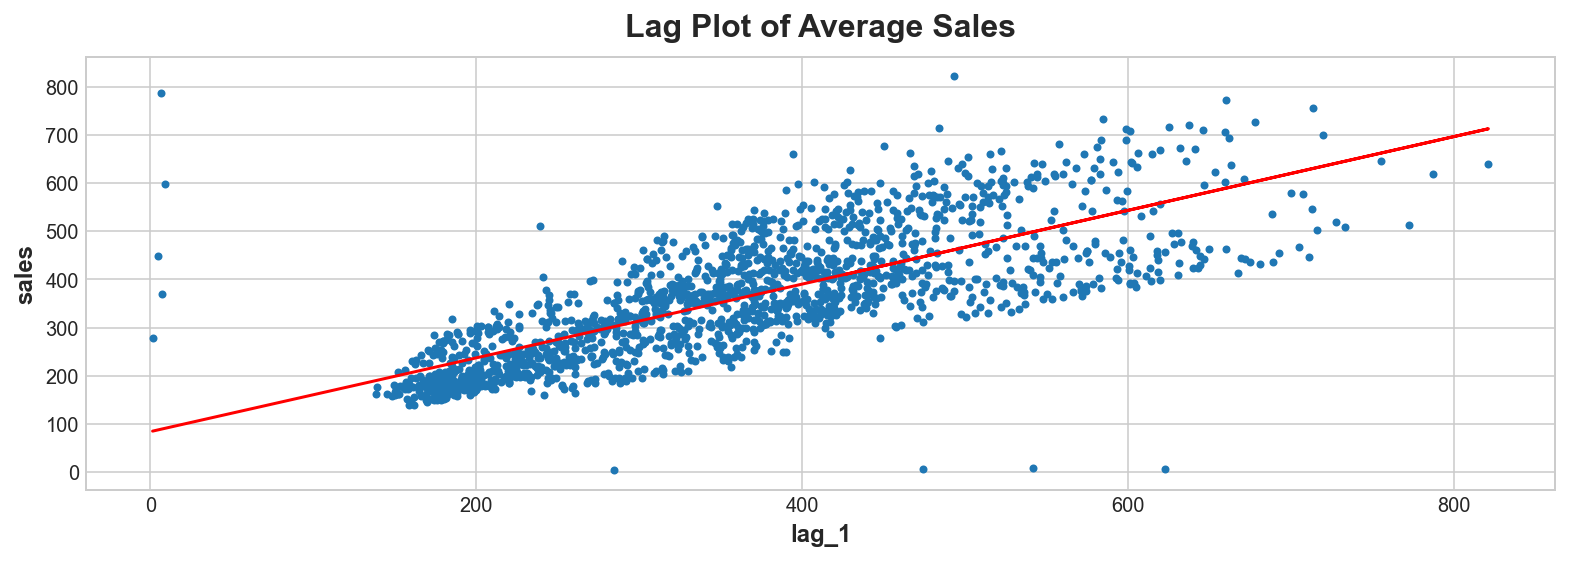

In [101]:
fig, ax = plt.subplots()
ax.plot(X['lag_1'], y, '.')
ax.plot(X['lag_1'], y_pred, color='red')
ax.set(ylabel='sales', xlabel='lag_1', title='Lag Plot of Average Sales');

# Trend

### Moving Average

In [128]:
trend = average_sales.rolling(
    window = 365,
    center = True,
    min_periods=183,
).mean()

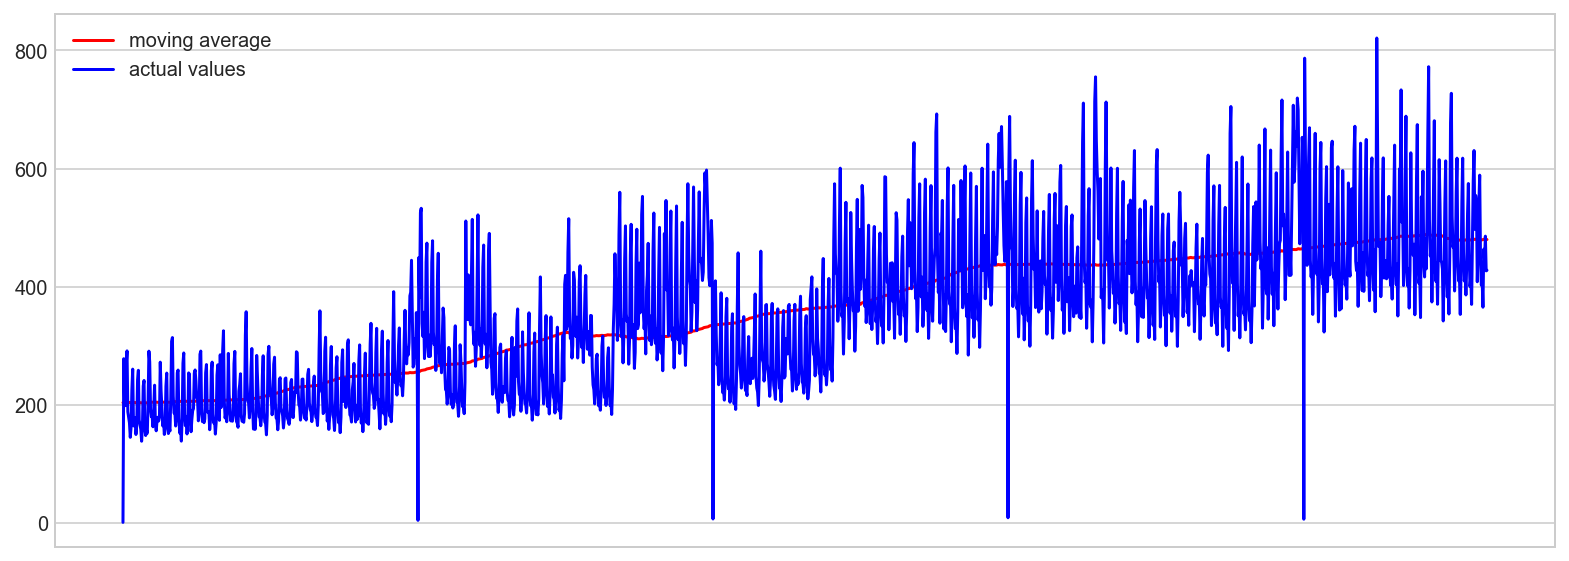

In [129]:
plt.plot(average_sales.index, trend, color='red', label='moving average')

plt.plot(average_sales.index, average_sales, color='blue', label='actual values')

plt.xticks([])
plt.legend()

### Trend Feature

In [130]:
from statsmodels.tsa.deterministic import DeterministicProcess

In [132]:
df.head()

,sales,time,lag_1
date,,,
2013-01-01,1.409438,0,NaN
2013-01-02,278.390807,1,1.409438
2013-01-03,202.840197,2,278.390807
2013-01-04,198.911154,3,202.840197
2013-01-05,267.873244,4,198.911154


In [148]:
y = average_sales.copy()

# A cubic trend model
dp = DeterministicProcess(index=y.index, order=3)

# Create the feature set for the dates given in y.index
X = dp.in_sample()

# Create features for a 365-day forecast.
X_fore = dp.out_of_sample(steps=365)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


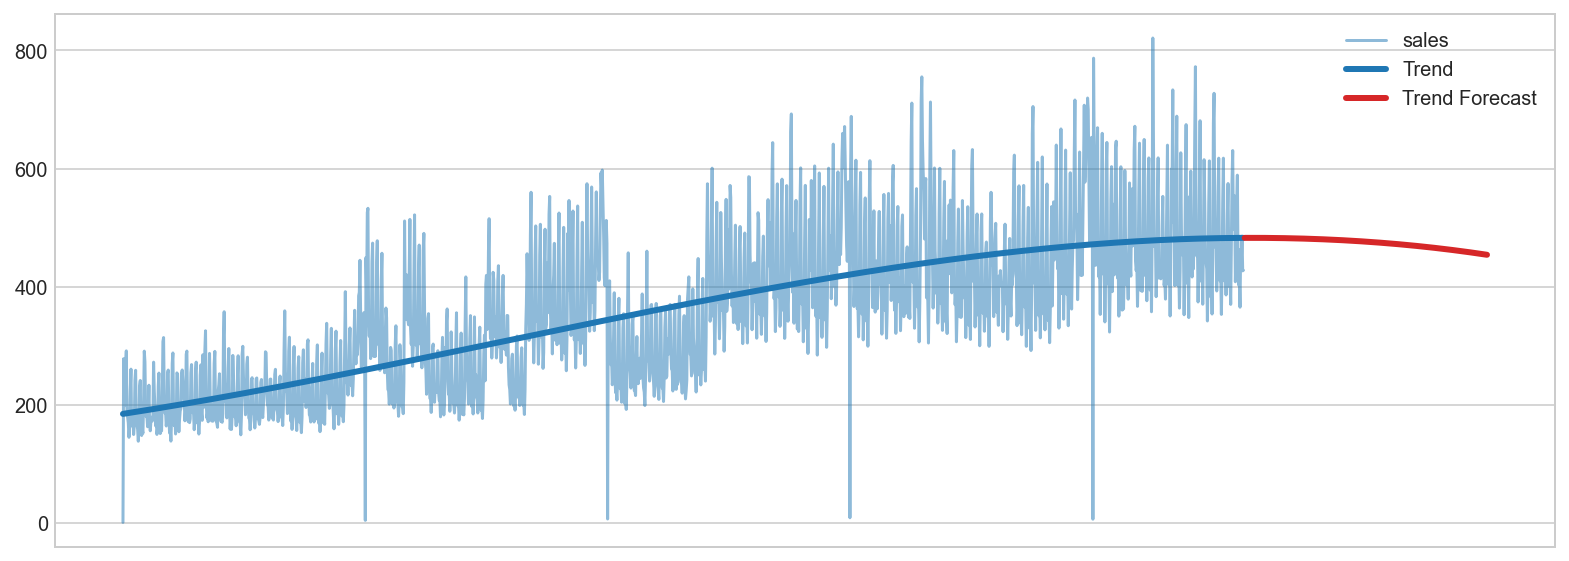

In [149]:
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

plt.plot(X.index, y, alpha=0.5, label='sales')
plt.plot(X.index, y_pred, linewidth=3, label="Trend", color='C0')
plt.plot(X_fore.index, y_fore, linewidth=3, label="Trend Forecast", color='C3')
plt.xticks([])
plt.legend()

In [341]:
store_sales = pd.read_csv(
    'store-sales-time-series-forecasting/train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2017']
)

In [345]:
# You'll add fit and predict methods to this minimal class
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method
        
    def fit(self, X_1, X_2, y):
        # Train model_1
        self.model_1.fit(X_1, y)

        # Make predictions
        y_fit = pd.DataFrame(
            self.model_1.predict(X_1), 
            index=X_1.index, columns=y.columns,
        )

        # Compute residuals
        y_resid = y - y_fit
        y_resid = y_resid.stack().squeeze() # wide to long

        # Train model_2 on residuals
        self.model_2.fit(X_2, y_resid)

        # Save column names for predict method
        self.y_columns = y.columns
        # Save data for question checking
        self.y_fit = y_fit
        self.y_resid = y_resid

    def predict(self, X_1, X_2):
        # Predict with model_1
        y_pred = pd.DataFrame(
            self.model_1.predict(X_1), 
            index=X_1.index, columns=self.y_columns,
        )
        y_pred = y_pred.stack().squeeze()  # wide to long

        # Add model_2 predictions to model_1 predictions
        y_pred += self.model_2.predict(X_2)

        return y_pred.unstack()



In [347]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.deterministic import DeterministicProcess
from xgboost import XGBRegressor

In [348]:
# Target series
y = family_sales.loc[:, 'sales']

# X_1: Features for Linear Regression
dp = DeterministicProcess(index=y.index, order=1)
X_1 = dp.in_sample()


# X_2: Features for XGBoost
X_2 = family_sales.drop('sales', axis=1).stack()  # onpromotion feature

# Label encoding for 'family'
le = LabelEncoder()  # from sklearn.preprocessing
X_2 = X_2.reset_index('family')
X_2['family'] = le.fit_transform(X_2['family'])

# Label encoding for seasonality
X_2["day"] = X_2.index.day  # values are day of the month

In [349]:
X_1

,trend
date,
2017-01-01,1.0
2017-01-02,2.0
2017-01-03,3.0
2017-01-04,4.0
2017-01-05,5.0
...,...
2017-08-11,223.0
2017-08-12,224.0
2017-08-13,225.0


In [350]:
X_2

,family,onpromotion,day
date,,,
2017-01-01,0,0.000000,1
2017-01-01,1,0.000000,1
2017-01-01,2,0.000000,1
2017-01-01,3,0.703704,1
2017-01-01,4,0.000000,1
...,...,...,...
2017-08-15,28,0.111111,15
2017-08-15,29,0.166667,15
2017-08-15,30,58.685185,15


In [351]:
model = BoostedHybrid(
    model_1=LinearRegression(),
    model_2=XGBRegressor(),
)
model.fit(X_1, X_2, y)

y_pred = model.predict(X_1, X_2)
y_pred = y_pred.clip(0.0)